In [115]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Load the data

In [116]:
fish_dir = 'Fish_Dataset' 

path = []
label = []


for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if filename.endswith('.png') and 'GT' not in dir_name:
            
            folder_name = dir_name.split(os.sep)[-1]
            
            label.append(folder_name)
            path.append(os.path.join(dir_name, filename))


data = pd.DataFrame({'path': path, 'label': label})

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [118]:
data['label'].value_counts(ascending=True)

label
Black Sea Sprat       1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Red Mullet            1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Striped Red Mullet    1000
Trout                 1000
Name: count, dtype: int64

Divide the dataset into training, validating and testing data

In [119]:
x_train, x_test = train_test_split(data, test_size=0.2, random_state=30, stratify=data['label'])
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30, stratify=x_train['label'])

In [120]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5760, 2)
Shape of test data (1800, 2)
Shape of validation data (1440, 2)


Preprocess the image

In [121]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [122]:
# Define the labels in sorted order
labels = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel',
          'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp',
          'Striped Red Mullet', 'Trout']
unique_labels = sorted(set(labels))

In [123]:
image_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.8, 1.2),
)

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle = True, class_names=unique_labels)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle = False, class_names=unique_labels)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='path', y_col='label', target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', class_mode='categorical', batch_size=BATCH_SIZE, shuffle = False, class_names=unique_labels)

Found 5760 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.


Define the model

In [124]:
cnn_model = tf.keras.models.Sequential()

# Input Layer
cnn_model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

# Layer 1
cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Layer 2
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Layer 3
cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Layer 4
cnn_model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Global Average Pooling
cnn_model.add(tf.keras.layers.GlobalAveragePooling2D())

# Fully Connected Layers
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.4))
cnn_model.add(tf.keras.layers.Dense(9, activation='softmax'))

cnn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,441 (1.75 MB)

 Trainable params: 457,481 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

In [125]:
Epochs = 50

save_path = f"cnn_1_model.keras"

Train the model

In [126]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Learning Rate Scheduler - ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',         # Metric to monitor (validation loss in this case)
    factor=0.2,                 # Factor by which the learning rate will be reduced
    patience=3,                 # Number of epochs with no improvement before reducing lr
    verbose=1,                  # Print out messages when the learning rate is reduced
    min_lr=1e-6                 # Minimum learning rate to prevent it from going to 0
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=6,                 # Number of epochs to wait for improvement before stopping
    restore_best_weights=True,  # Restore the best model weights
    verbose=1                   # Print when early stopping occurs
)

# ModelCheckpoint Callback to save the best model
checkpoint_callback = ModelCheckpoint(
    filepath=save_path,         # Path to save the model
    monitor='val_loss',         # Metric to monitor
    save_best_only=True,        # Save only the best model
    mode='min',                 # Save when 'val_loss' is minimized
    verbose=1                   # Print information about saving
)

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=["accuracy"])

# Fit the model with all the callbacks
history = cnn_model.fit(
    train,
    validation_data=val,
    epochs=Epochs,
    callbacks=[checkpoint_callback, early_stopping, lr_scheduler]  # Include the callbacks here
)


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3956 - loss: 1.6800
Epoch 1: val_loss improved from inf to 2.16822, saving model to cnn_1_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.3961 - loss: 1.6785 - val_accuracy: 0.3625 - val_loss: 2.1682 - learning_rate: 0.0100
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.6108 - loss: 1.0428
Epoch 2: val_loss improved from 2.16822 to 1.26264, saving model to cnn_1_model.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6110 - loss: 1.0422 - val_accuracy: 0.5694 - val_loss: 1.2626 - learning_rate: 0.0100
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.7670 - loss: 0.6686
Epoch 3: val_loss did not improve from 1.26264
180/180 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.7670 - loss: 0.6685 - val_accuracy: 0.3194 - val_loss: 4.7667 - learning_rate: 0.0100
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7685 - loss: 0.6460
Epoch 4: val_

Check the model's performance

In [127]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

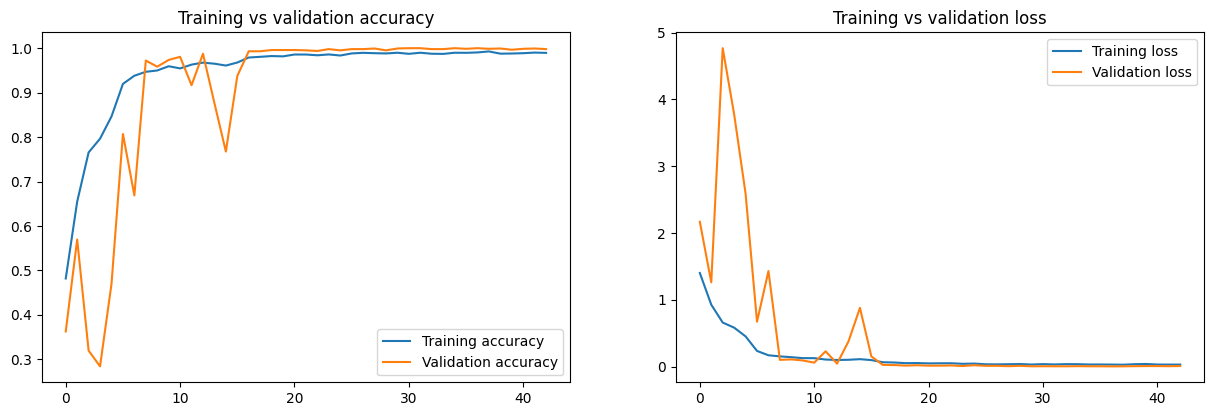

In [128]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

Load saved model and make prediction

In [129]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(save_path)

# Optionally, print the model's summary to verify the structure
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,373,405 (5.24 MB)

 Trainable params: 457,481 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 914,964 (3.49 MB)

In [131]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions from the model
pred = model.predict(test)
pred = np.argmax(pred, axis=1)  # Convert the one-hot encoded predictions to class indices

# Get the true labels from the test generator
true_labels = test.labels  # These are already class indices

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_labels, pred, target_names=list(test.class_indices.keys()))

# Print the classification report
print("\nClassification Report:")
print(class_report)



57/57 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step
Confusion Matrix:
[[200   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0]
 [  0   0   0 200   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0]
 [  0   0   0   0   0 200   0   0   0]
 [  0   0   0   0   0   0 200   0   0]
 [  0   0   0   0   0   0   0 200   0]
 [  0   0   0   0   0   0   0   0 200]]

Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       200
   Gilt-Head Bream       1.00      1.00      1.00       200
   Hourse Mackerel       1.00      1.00      1.00       200
        Red Mullet       1.00      1.00      1.00       200
     Red Sea Bream       1.00      1.00      1.00       200
          Sea Bass       1.00      1.00      1.00       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       1.00      1.00      1.00       200
             Trout       1